## Imports

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import math
from math import sqrt
import glob
import cv2 as cv
import copy
import matplotlib.pyplot as plt
import os
import time
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings('always')

Mounted at /content/drive


In [ ]:
from keras.applications.resnet import ResNet50
from keras.models import load_model

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.metrics import Metric
from tensorflow.python.keras.utils import metrics_utils
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.keras.utils.generic_utils import to_list

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(

In [ ]:
# importing image data
path = "/content/*.*"

X, y = [], []

for img in glob.glob(path):
  X.append(cv.imread(img))
  y.append(str(img[9]))

y = pd.get_dummies(pd.Series(list(y)))

# train-test-split (60-40)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## Pre-processing

In [ ]:
def normalize_pixel(x, v0, v, m, m0):
    """
    From Handbook of Fingerprint Recognition pg 133
    Normalize job used by Hong, Wan and Jain(1998)
    similar to https://pdfs.semanticscholar.org/6e86/1d0b58bdf7e2e2bb0ecbf274cee6974fe13f.pdf equation 21
    :param x: pixel value
    :param v0: desired variance
    :param v: global image variance
    :param m: global image mean
    :param m0: desired mean
    :return: normilized pixel
    """
    dev_coeff = sqrt((v0 * ((x - m)**2)) / v)
    return m0 + dev_coeff if x > m else m0 - dev_coeff

def normalize(im, m0, v0):
    m = np.mean(im)
    v = np.std(im) ** 2
    (y, x) = im.shape
    normilize_image = im.copy()
    for i in range(x):
        for j in range(y):
            normilize_image[j, i] = normalize_pixel(im[j, i], v0, v, m, m0)

    return normilize_image

In [ ]:
def normalise(img):
    return (img - np.mean(img))/(np.std(img))

def create_segmented_and_variance_images(im, w, threshold=.2):
    """
    Returns mask identifying the ROI. Calculates the standard deviation in each image block and threshold the ROI
    It also normalises the intesity values of
    the image so that the ridge regions have zero mean, unit standard
    deviation.
    :param im: Image
    :param w: size of the block
    :param threshold: std threshold
    :return: segmented_image
    """
    (y, x) = im.shape
    threshold = np.std(im)*threshold

    image_variance = np.zeros(im.shape)
    segmented_image = im.copy()
    mask = np.ones_like(im)

    for i in range(0, x, w):
        for j in range(0, y, w):
            box = [i, j, min(i + w, x), min(j + w, y)]
            block_stddev = np.std(im[box[1]:box[3], box[0]:box[2]])
            image_variance[box[1]:box[3], box[0]:box[2]] = block_stddev

    # apply threshold
    mask[image_variance < threshold] = 0

    # smooth mask with a open/close morphological filter
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(w*2, w*2))
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)

    # normalize segmented image
    segmented_image *= mask
    im = normalise(im)
    mean_val = np.mean(im[mask==0])
    std_val = np.std(im[mask==0])
    norm_img = (im - mean_val)/(std_val)

    return segmented_image, norm_img, mask

In [ ]:
def calculate_angles(im, W, smoth=False):
    """
    anisotropy orientation estimate, based on equations 5 from:
    https://pdfs.semanticscholar.org/6e86/1d0b58bdf7e2e2bb0ecbf274cee6974fe13f.pdf
    :param im:
    :param W: int width of the ridge
    :return: array
    """
    j1 = lambda x, y: 2 * x * y
    j2 = lambda x, y: x ** 2 - y ** 2
    j3 = lambda x, y: x ** 2 + y ** 2

    (y, x) = im.shape

    sobelOperator = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    ySobel = np.array(sobelOperator).astype(int)
    xSobel = np.transpose(ySobel).astype(int)

    result = [[] for i in range(1, y, W)]

    Gx_ = cv.filter2D(im/125,-1, ySobel)*125
    Gy_ = cv.filter2D(im/125,-1, xSobel)*125

    for j in range(1, y, W):
        for i in range(1, x, W):
            nominator = 0
            denominator = 0
            for l in range(j, min(j + W, y - 1)):
                for k in range(i, min(i + W , x - 1)):
                    Gx = round(Gx_[l, k])  # horizontal gradients at l, k
                    Gy = round(Gy_[l, k])  # vertial gradients at l, k
                    nominator += j1(Gx, Gy)
                    denominator += j2(Gx, Gy)

            # nominator = round(np.sum(Gy_[j:min(j + W, y - 1), i:min(i + W , x - 1)]))
            # denominator = round(np.sum(Gx_[j:min(j + W, y - 1), i:min(i + W , x - 1)]))
            if nominator or denominator:
                angle = (math.pi + math.atan2(nominator, denominator)) / 2
                orientation = np.pi/2 + math.atan2(nominator,denominator)/2
                result[int((j-1) // W)].append(angle)
            else:
                result[int((j-1) // W)].append(0)

            # segment image
            # focus_img = im[j:min(j + W, y - 1), i:min(i + W , x - 1)]
            # segmentator = -1 if segmentator/W*W < np.max(focus_img)*

    result = np.array(result)

    if smoth:
        result = smooth_angles(result)

    return result


def gauss(x, y):
    ssigma = 1.0
    return (1 / (2 * math.pi * ssigma)) * math.exp(-(x * x + y * y) / (2 * ssigma))


def kernel_from_function(size, f):
    kernel = [[] for i in range(0, size)]
    for i in range(0, size):
        for j in range(0, size):
            kernel[i].append(f(i - size / 2, j - size / 2))
    return kernel


def smooth_angles(angles):
    """
    reference: https://airccj.org/CSCP/vol7/csit76809.pdf pg91
    Practically, it is possible to have a block so noisy that the directional estimate is completely false.
    This then causes a very large angular variation between two adjacent blocks. However, a
    fingerprint has some directional continuity, such a variation between two adjacent blocks is then
    representative of a bad estimate. To eliminate such discontinuities, a low-pass filter is applied to
    the directional board.
    :param angles:
    :return:
    """
    angles = np.array(angles)
    cos_angles = np.cos(angles.copy()*2)
    sin_angles = np.sin(angles.copy()*2)

    kernel = np.array(kernel_from_function(5, gauss))

    cos_angles = cv.filter2D(cos_angles/125,-1, kernel)*125
    sin_angles = cv.filter2D(sin_angles/125,-1, kernel)*125
    smooth_angles = np.arctan2(sin_angles, cos_angles)/2

    return smooth_angles


def get_line_ends(i, j, W, tang):
    if -1 <= tang and tang <= 1:
        begin = (i, int((-W/2) * tang + j + W/2))
        end = (i + W, int((W/2) * tang + j + W/2))
    else:
        begin = (int(i + W/2 + W/(2 * tang)), j + W//2)
        end = (int(i + W/2 - W/(2 * tang)), j - W//2)
    return (begin, end)


def visualize_angles(im, mask, angles, W):
    (y, x) = im.shape
    result = cv.cvtColor(np.zeros(im.shape, np.uint8), cv.COLOR_GRAY2RGB)
    mask_threshold = (W-1)**2
    for i in range(1, x, W):
        for j in range(1, y, W):
            radian = np.sum(mask[j - 1:j + W, i-1:i+W])
            if radian > mask_threshold:
                tang = math.tan(angles[(j - 1) // W][(i - 1) // W])
                (begin, end) = get_line_ends(i, j, W, tang)
                cv.line(result, begin, end, color=(255, 255, 255))

    cv.resize(result, im.shape, result)
    return result

## Pre-processing the data

In [ ]:
X_train_orient = []
for input_img in np.array(X_train)[:,:,:,0]:
  normalized_img = normalize(input_img.copy(), float(100), float(100))

  # ROI and normalisation
  (segmented_img, normim, mask) = create_segmented_and_variance_images(normalized_img, 16, 0.2)

  # orientations
  angles = calculate_angles(normalized_img, W=16, smoth=False)
  orientation_img = visualize_angles(segmented_img, mask, angles, W=16)

  X_train_orient.append(orientation_img)

In [ ]:
X_test_orient = []
for input_img in np.array(X_test)[:,:,:,0]:
  normalized_img = normalize(input_img.copy(), float(100), float(100))

  # ROI and normalisation
  (segmented_img, normim, mask) = create_segmented_and_variance_images(normalized_img, 16, 0.2)

  # orientations
  angles = calculate_angles(normalized_img, W=16, smoth=False)
  orientation_img = visualize_angles(segmented_img, mask, angles, W=16)

  X_test_orient.append(orientation_img)

In [ ]:
# converting to float32 numpy arrays
X_train_orient = np.array(X_train_orient).astype('float32')
X_test_orient = np.array(X_test_orient).astype('float32')

In [ ]:
# defining the transformations
datagen = ImageDataGenerator(
    width_shift_range= 2.0,
    height_shift_range= 2.0,
    rotation_range = 20,
    fill_mode = 'constant',
)

# creating an iterator for augmented training images
datagen.fit(np.array(X_train_orient))
data_generator = datagen.flow(np.array(X_train_orient), y_train, shuffle=False, batch_size=1)

In [ ]:
# creating an iterator for test data
datagen.fit(np.array(X_test_orient))
test_generator = datagen.flow(np.array(X_test_orient), y_test, shuffle=False, batch_size=1)

## Custom Metrics

In [ ]:
class balanced_acc(Metric):

    def __init__(self, thresholds=None, top_k=None, class_id=None, name=None, dtype=None):
        super(balanced_acc, self).__init__(name=name, dtype=dtype)
        self.init_thresholds = thresholds
        self.top_k = top_k
        self.class_id = class_id

        default_threshold = 0.5 if top_k is None else metrics_utils.NEG_INF
        self.thresholds = metrics_utils.parse_init_thresholds(
            thresholds, default_threshold=default_threshold)
        self.true_positives = self.add_weight(
            'true_positives',
            shape=(len(self.thresholds),),
            initializer=init_ops.zeros_initializer)
        self.true_negatives = self.add_weight(
            'true_negatives',
            shape=(len(self.thresholds),),
            initializer=init_ops.zeros_initializer)
        self.false_positives = self.add_weight(
            'false_positives',
            shape=(len(self.thresholds),),
            initializer=init_ops.zeros_initializer)
        self.false_negatives = self.add_weight(
            'false_negatives',
            shape=(len(self.thresholds),),
            initializer=init_ops.zeros_initializer)

    def update_state(self, y_true, y_pred, sample_weight=None):

        return metrics_utils.update_confusion_matrix_variables(
            {
                metrics_utils.ConfusionMatrix.TRUE_POSITIVES: self.true_positives,
                metrics_utils.ConfusionMatrix.TRUE_NEGATIVES: self.true_negatives,
                metrics_utils.ConfusionMatrix.FALSE_POSITIVES: self.false_positives,
                metrics_utils.ConfusionMatrix.FALSE_NEGATIVES: self.false_negatives,
            },
            y_true,
            y_pred,
            thresholds=self.thresholds,
            top_k=self.top_k,
            class_id=self.class_id,
            sample_weight=sample_weight)

    def result(self):
        """
        Returns the Balanced Accuracy (average between recall and specificity)
        """
        result = (math_ops.div_no_nan(self.true_positives, self.true_positives + self.false_negatives) +
                  math_ops.div_no_nan(self.true_negatives, self.true_negatives + self.false_positives)) / 2
        
        return result

    def reset_states(self):
        num_thresholds = len(to_list(self.thresholds))
        K.batch_set_value(
            [(v, np.zeros((num_thresholds,))) for v in (self.true_positives,self.true_negatives, self.false_negatives, self.false_positives)])

    def get_config(self):
        config = {
            'thresholds': self.init_thresholds,
            'top_k': self.top_k,
            'class_id': self.class_id
        }
        base_config = super(balanced_acc, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = tf.cast(y_true, dtype=tf.float32) * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [ ]:
# defining loss weights
weighted_loss = weighted_categorical_crossentropy(np.array([0.14, 0.04, 0.11, 0.2, 0.25]))

## FCTP Model

In [ ]:
model_fctp = tf.keras.Sequential()

model_fctp.add(layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(480, 640, 3)))
model_fctp.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model_fctp.add(layers.Lambda(tf.nn.local_response_normalization))

model_fctp.add(layers.Conv2D(filters=256, kernel_size=(5,5), activation='relu'))
model_fctp.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model_fctp.add(layers.Lambda(tf.nn.local_response_normalization))

model_fctp.add(layers.Conv2D(filters=384, kernel_size=(3,3), activation='relu'))
model_fctp.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model_fctp.add(layers.Lambda(tf.nn.local_response_normalization))

model_fctp.add(layers.Conv2D(filters=384, kernel_size=(2,2), activation='relu'))
model_fctp.add(layers.MaxPooling2D(pool_size=(2,2)))
model_fctp.add(layers.Lambda(tf.nn.local_response_normalization))

model_fctp.add(layers.Flatten())

model_fctp.add(layers.Dense(units=4096, activation='relu'))
model_fctp.add(layers.Dropout(0.2))
model_fctp.add(layers.Dense(units=4096, activation='relu'))
model_fctp.add(layers.Dropout(0.2))
model_fctp.add(layers.Dense(units=5, activation='softmax'))

model_fctp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 118, 158, 96)      34944     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 58, 78, 96)       0         
 2D)                                                             
                                                                 
 lambda_4 (Lambda)           (None, 58, 78, 96)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 54, 74, 256)       614656    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 36, 256)      0         
 2D)                                                             
                                                                 
 lambda_5 (Lambda)           (None, 26, 36, 256)      

In [ ]:
# training the fctp model
model_fctp.compile(loss = weighted_loss, optimizer = 'adam', metrics = [balanced_acc()])
history = model_fctp.fit(data_generator, steps_per_epoch=20, epochs=4, verbose=1)

Epoch 1/4
20/20 [==============================] - 2s 74ms/step - loss: 1.4909 - balanced_acc_3: 0.6249
Epoch 2/4
20/20 [==============================] - 1s 72ms/step - loss: 1.0154 - balanced_acc_3: 0.6655
Epoch 3/4
20/20 [==============================] - 1s 71ms/step - loss: 1.4184 - balanced_acc_3: 0.6791
Epoch 4/4
20/20 [==============================] - 1s 73ms/step - loss: 1.1686 - balanced_acc_3: 0.6641


In [ ]:
# testing the fctp model
model_fctp.evaluate(test_generator)

32/32 [==============================] - 2s 64ms/step - loss: 1.2492 - balanced_acc_3: 0.6700


[1.2491525411605835, 0.6700236797332764]

## ResNet50 Model

In [ ]:
# pre-trained ResNet50 architecture
base_model = ResNet50(input_shape=(480,640,3), weights='imagenet', include_top=False)
base_model.trainable = False # freeze the layers
base_model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 486, 646, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 240, 320, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
# adding output layer (5 class softmax layer)
ResNet50Model = tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(5, activation='softmax')
])
ResNet50Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 15, 20, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 614400)            0         
                                                                 
 dense (Dense)               (None, 5)                 3072005   
                                                                 
Total params: 26,659,717
Trainable params: 3,072,005
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# training the ResNet50 model
ResNet50Model.compile(loss = weighted_loss, optimizer = 'adam', metrics = [balanced_acc()])
history1 = ResNet50Model.fit(data_generator, steps_per_epoch=20, epochs=4, verbose=1)

Epoch 1/4
20/20 [==============================] - 25s 1s/step - loss: 1.0799 - balanced_acc_2: 0.7602
Epoch 2/4
20/20 [==============================] - 21s 1s/step - loss: 1.0316 - balanced_acc_2: 0.7767
Epoch 3/4
20/20 [==============================] - 21s 1s/step - loss: 1.0799 - balanced_acc_2: 0.7360
Epoch 4/4
20/20 [==============================] - 21s 1s/step - loss: 0.9913 - balanced_acc_2: 0.7341


In [ ]:
# testing the ResNet50 model
ResNet50Model.evaluate(test_generator)

32/32 [==============================] - 35s 1s/step - loss: 1.2794 - balanced_acc_2: 0.7445


[1.2793738842010498, 0.7445114254951477]

## Saving pre-processed images to folders

In [ ]:
np.array(y).shape

(80, 5)

In [ ]:
X_orient = []
for input_img in np.array(X)[:,:,:,0]:
  normalized_img = normalize(input_img.copy(), float(100), float(100))

  # ROI and normalisation
  (segmented_img, normim, mask) = create_segmented_and_variance_images(normalized_img, 16, 0.2)

  # orientations
  angles = calculate_angles(normalized_img, W=16, smoth=False)
  orientation_img = visualize_angles(segmented_img, mask, angles, W=16)

  X_orient.append(orientation_img)

X_orient = np.array(X_orient).astype('float32')

In [ ]:
X_orient.shape

(80, 480, 640, 3)

In [ ]:
!mkdir './oriented/'

In [ ]:
!cd './oriented/'

In [ ]:
from PIL import Image
for i in range(0,80):
  im = Image.fromarray((X_orient[i]).astype(np.uint8))
  im.save("./oriented/" + str(i)+ "_" + y[i] + ".tif")

In [ ]:
im = Image.open(r'./oriented/72_T.png')
im

In [ ]:
for i in list(set(y)):
    os.makedirs(os.path.join("./oriented/", i))

In [ ]:
path = "./oriented/*.png"

for img in sorted(glob.glob(path)):
  label = img[len(img) - 5]
  os.rename(img, f"./oriented/{label}/{os.path.basename(img)}")

## Time taken to classify input and search a subfolder

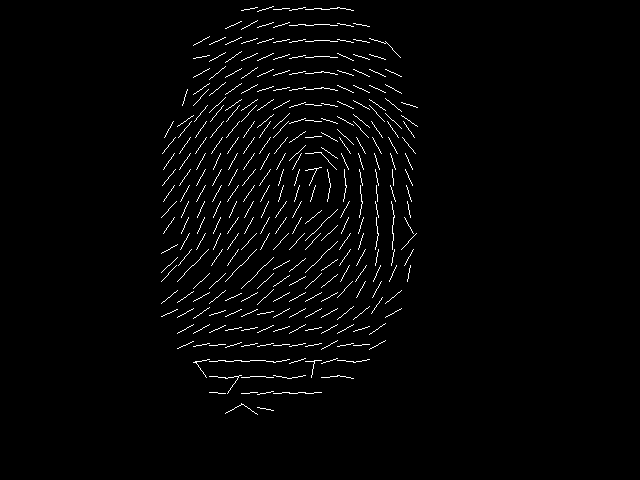

In [ ]:
start_time = time.time()

# preprocessing the input image

input = np.array(Image.open('/content/L_107_5.tif'))
normalized_img = normalize(input, float(100), float(100))

# ROI and normalisation
(segmented_img, normim, mask) = create_segmented_and_variance_images(normalized_img, 16, 0.2)

# orientations
angles = calculate_angles(normalized_img, W=16, smoth=False)
orientation_img = visualize_angles(segmented_img, mask, angles, W=16)

cv2_imshow(orientation_img)

In [ ]:
#ResNet50Model.predict(orientation_img)
res = list(ResNet50Model.predict(np.array([orientation_img]))[0])
print(res)

1/1 [==============================] - 1s 1s/step
[0.0, 1.0, 0.0, 0.0, 0.0]


In [ ]:
y.value_counts()

D  L  R  T  W
0  1  0  0  0    40
   0  1  0  0    16
      0  0  1     8
         1  0     8
1  0  0  0  0     8
dtype: int64

In [ ]:
if res[0] == 1.0:
  label = "D"
  pr = 10
if res[1] == 1.0:
  label = "L"
  pr = 50
if res[2] == 1.0:
  label = "R"
  pr = 20
if res[3] == 1.0:
  label = "T"
  pr = 10
if res[4] == 1.0:
  label = "W"
  pr = 10

print(f"Class predicted: {label}")

Class predicted: L


Best match: 20_L.png
Search time: 18.61470937728882 seconds
Penetration rate: 50%



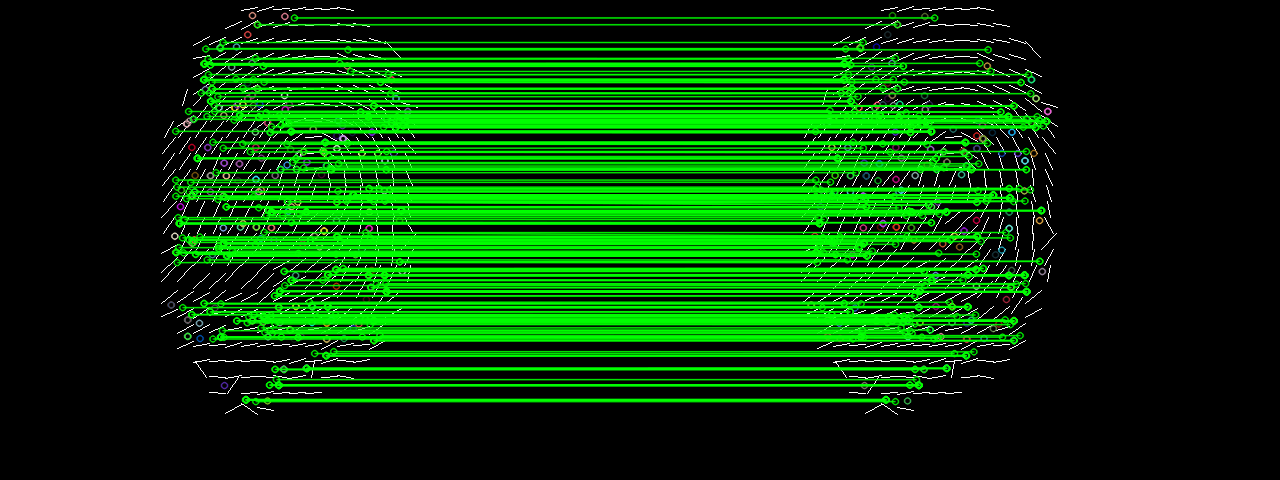

In [ ]:
# finding features to match

input_img = orientation_img
input_img=input_img.astype('uint8')
gray= cv.cvtColor(input_img,cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
kp = sift.detect(input_img,None)
img1=cv.drawKeypoints(input_img,kp,input_img)

flag=0
max=0

# switching to the required subfolder
os.chdir(f"/content/oriented/{label}")

# searching through the subfolder
for file in glob.glob("*.tif", recursive=True):

    frame=cv.imread(file)
    frame=frame.astype('uint8')
    gray1 = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    sift = cv.xfeatures2d.SIFT_create()
    kp = sift.detect(frame,None)
    img2=cv.drawKeypoints(frame,kp,frame)
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches=flann.knnMatch(np.asarray(des1,np.float32), np.asarray(des2,np.float32),k=2)

    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    if len(good)>10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        #print("Matched " + str(file))
        if (len(matchesMask)) > max:
          i1 = img1
          i2 = img2
          k1 = kp1
          k2 = kp2
          best = good
          draw_params = dict(matchColor = (0, 255, 0), # draw matches in green color
                singlePointColor = None,
                matchesMask = matchesMask, # draw only inliers
                flags = 2)
          fname = str(file)
          max = len(matchesMask)
        flag=1

    else:
        matchesMask = None

print("Best match:", fname)
print("Search time: %s seconds" % (time.time() - start_time))

print(f"Penetration rate: {pr}%")
print()

img3 = cv.drawMatches(i1, k1, i2, k2, best, None, **draw_params)
cv2_imshow(img3)

if flag==0:
    print("No matches found!")